<a href="https://colab.research.google.com/github/igolovko3/seam_carving/blob/main/seam_carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import time
import IPython

In [ ]:
from google.colab import drive

# to run on Colab mount drive and move to the rerository with your images
# otherwise, skip this cell and just put .ipynb to the same location as images

drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Seam Carving'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Seam Carving


In [ ]:
#@title Body of the engine (run before using anything else!)

def image_reader(name, downscale=1, covnvert_color=True):

  raw_img = cv2.imread(name)

  # convert colors to RGB to show images in pyplot 
  if covnvert_color:
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

  # downscale the image proportionally to reduce computation costs
  size = (int(raw_img.shape[1]*downscale), int(raw_img.shape[0]*downscale))
  img = cv2.resize(raw_img, size)

  print(f'Raw image size: {raw_img.shape[:2]}')
  print(f'Rescaled image size: {img.shape[:2]}')

  return img, raw_img

def flowDP(arr):
    # calculate the minimal weight path to each pixel
    # row by row using DP approach
    
    nrows = arr.shape[0]
    ncols = arr.shape[1]
    
    # initialize the array for DP calculation
    # first and last column are inf to mark the borders of the image
    res = np.zeros((nrows, ncols + 2))
    res[:, 0] = np.inf
    res[:, ncols+1] = np.inf
        
    res[0, 1:ncols+1] = arr[0]
    
    # recursively calculate shortest cumulative path to each cell row by row
    for i in range(1, nrows):
        for j in range(1, ncols+1):
            # note: initial array has j-index shifted by one to the left
            res[i, j] = arr[i, j-1] + np.min([res[i-1, j-1], res[i-1, j], res[i-1, j+1]])
            
    return res[:, 1:ncols+1]

def shortestpath(flow):
    # trace back the indices of the shortest path
    # given the length of the shortest path to each cell
    
    nrows = flow.shape[0]
    ncols = flow.shape[1]
    
    # create the augmented "flow" by adding the infinite
    # border columns
    flow_aug = np.zeros((nrows, ncols + 2))
    flow_aug[:, 0] = np.inf
    flow_aug[:, ncols+1] = np.inf  
    flow_aug[:, 1: ncols+1] = flow
    
    # find the end of the shortest path, i.e. index of cell with
    # smallest value in the last row
    route = [np.argmin(flow_aug[nrows-1,:])]
    
    # iteratively trace the path upwards 
    for i in range(nrows-2, -1, -1):
        col = route[-1]
        
    # the path comes to the pixel from one of three above it
        route.append(col - 1 + np.argmin([
            flow_aug[i, col-1],
            flow_aug[i, col],
            flow_aug[i, col+1]
        ]))
    
    return np.array(route[::-1]) - 1

def laplasian_energy(img):
    
    # laplacian-based energy function of image     

    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    lap = cv2.Laplacian(img_mono, cv2.CV_64F, ksize=3)
    lap = np.uint8(np.abs(lap))
    
    return lap
    
def gradient_energy_conv(img):
    
    # gradient-based (Sobel operator) energy function of image 

    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(img_mono, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_mono, cv2.CV_64F, 0, 1, ksize=3)

    grad = np.abs(grad_x) + np.abs(grad_y) # l1-norm originally used in the artile
#     grad = np.sqrt(grad_x**2 + grad_y**2) # l2-norm
    
    return grad
    
def seam_carve_compress(original_img, *, n_iter=None, frac=0.3, energy_func=gradient_energy_conv, 
               spt_calulator=flowDP, axis=1, save_animation=False, save_path='animation/'):
    """
    Main function to perform seam carving (compression part)
    
    Arguments:
    
    * original_img
    Source image to transform
    
    * n_iter: int, default=None
    Number of seams to carve. If not specified, use the frac parameter to determine
    the number of seams to be removed

    * frac: float between 0 and 1, default=0.3
    Fraction of the seams to be carved. Is relevant only if n_iter is not specified

    * energy_func: callable, default=gradient_energy_conv
    Function that is called on the image to calculate the importance of pixels

    * spt_calulator: callable, default=flowDP
    Function that is called on the energy map of the image to find the shortest path

    * axis: {0, 1}, default=1
    Determines the direction in which to perform seam carving: 1 corresponds to removing
    vertical seams, 0 - horizontal

    * save_animation: bool, default=False
    Parameter specifying if saving intermediate results (after removing each seam) is necessary
    Saved images can be compiled into a smooth resizing animation

    * save_path: str, default='animation/'
    Path to save the intermediate results when save_animation=True
    """

    out = display(IPython.display.Pretty('Starting...'), display_id=True)
    
    img = original_img.copy()
    
    if not n_iter:
        n_iter = int(frac*img.shape[axis])
        
    if axis == 0:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    # an array to store the history of seam deletion
    del_map = np.zeros(img.shape[:2], dtype=np.int8)
        
    tic = time.time()
    ncols_orig = img.shape[0]
        
    for i in range(n_iter):
        
        # this loop on each step finds the cheapest seam to remove, removes it
        # and marks the coordinates of the removed seam on the original image

        energy = energy_func(img)
        flow = flowDP(energy)
        path = shortestpath(flow)
        
        nrows, ncols = energy.shape
        
        # save intermediate pictures to produce animation
        if save_animation:
            img_seam = img.copy()
            img_seam[np.arange(ncols) == np.array(path)[:, None]] = [0, 0, 255]
            img_framed = np.concatenate((img_seam, 255*np.ones((nrows, i, 3), dtype=np.uint8)), axis=1)
            cv2.imwrite(save_path + f'{2*i}.png', img_framed)    
        
        # delete the lowest-energy path from the image and mark it on the deletion map
        img = img[np.arange(ncols) != np.array(path)[:, None]].reshape(nrows,-1, 3)
        map_temp = del_map[del_map == 0].reshape(nrows,-1)
        map_temp[(np.arange(ncols) == np.array(path)[:, None])] = 1
        del_map[del_map == 0] = map_temp.flatten()
        
        if save_animation:
            img_framed = np.concatenate((img, 255*np.ones((nrows, i+1, 3), dtype=np.uint8)), axis=1)
            cv2.imwrite(save_path + f'{2*i+1}.png', img_framed)        
        
        # timer interface
        toc = time.time()
        out.update(IPython.display.Pretty(
            f'Iteration {i + 1}/{n_iter}' 
            f'\nElapsed time: {np.round((toc - tic), 1)}s,'
            f'\nEstimated time left: {np.round((toc - tic) * (n_iter / (i + 1) - 1), 1)}s,' 
            ))
        
    if axis == 0:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        del_map = np.rot90(del_map)

    return img, del_map

def overlay_map(img, map):

  # show the deleted seams on the original image
  img_carved = img.copy()
  img_carved[del_map==1] = [0, 0, 255]

  return img_carved

def seam_carve_enlarge(original_img, del_map, axis = 1):

  # Use the map of the deleted seams to insert an additional seam
  # along each one that would have been removed from the original image

  img = original_img.copy()
  
  if axis == 0:
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    del_map = np.rot90(del_map, -1)
  
  n_new_seams = del_map[0].sum()
  
  img_left = img.copy()
  img_left = np.concatenate((
      img_left,
      img[:, [-1], :]
  ), axis=1)

  img_right = img.copy()
  img_right = np.concatenate((
      img[:, [0], :],
      img_right
  ), axis=1)

  new_seams = (0.5*img_left + 0.5*img_right)[:, :-1]
  new_seams[del_map == 0] = 0

  img_enlarged = np.zeros((img.shape[0], img.shape[1] + n_new_seams, 3), dtype = np.float16)
  img_enlarged[:] = np.nan

  cumsum = np.cumsum(del_map, axis = 1)
  mask = np.where(del_map)
  mask = (mask[0], mask[1] + cumsum[del_map == 1])
  
  img_enlarged[mask] = new_seams[del_map==1]
  img_enlarged[np.isnan(img_enlarged)] = img.ravel()

  img_enlarged = img_enlarged.astype(np.uint8)

  if axis == 0:
    img_enlarged = cv2.rotate(img_enlarged, cv2.ROTATE_90_COUNTERCLOCKWISE)
    del_map = np.rot90(del_map, 1)

  return img_enlarged

In [ ]:
# Downscaling the image is ment to increase the speed of processing
img, raw_img = image_reader('trees1.jpg', downscale=0.4)

Raw image size: (974, 1500)
Rescaled image size: (389, 600)


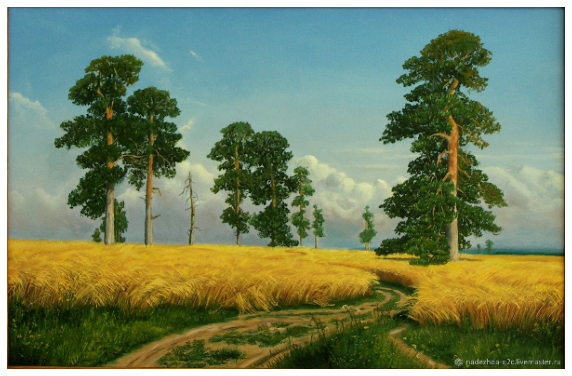

In [ ]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img);

In [ ]:
sc, del_map = seam_carve_compress(img, energy_func=gradient_energy_conv, n_iter=200)

Iteration 209/300
Elapsed time: 365.0s,
Estimated time left: 158.9s,

Iteration 224/300
Elapsed time: 385.5s,
Estimated time left: 130.8s,

In [ ]:
img_carved = overlay_map(img, del_map)

In [ ]:
# USE SAME AXIS FOR seam_carve_compress and seam_carve_enlarge (default is axis=1)!
enlarged = seam_carve_enlarge(img, del_map)

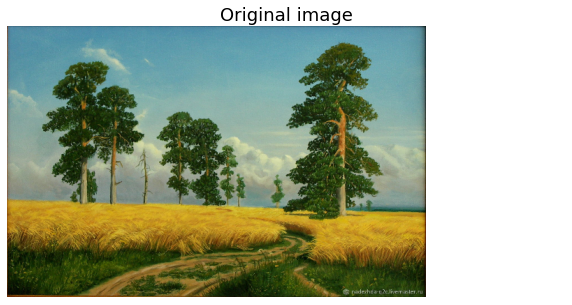

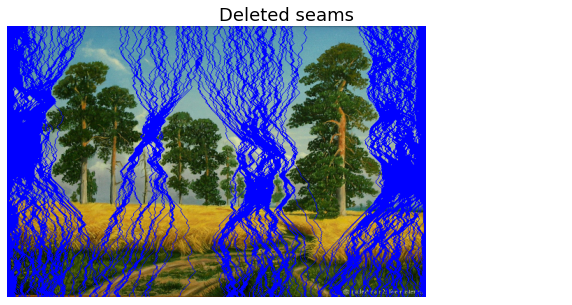

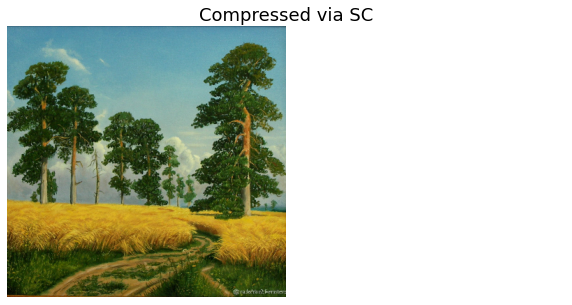

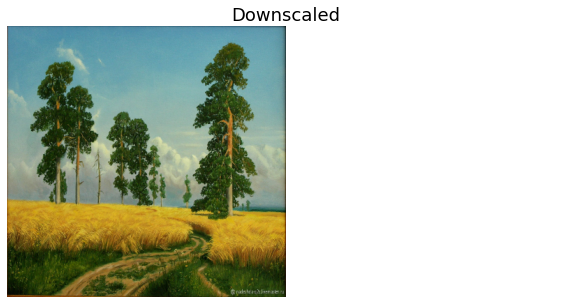

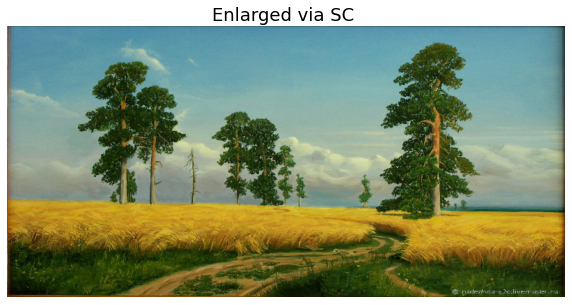

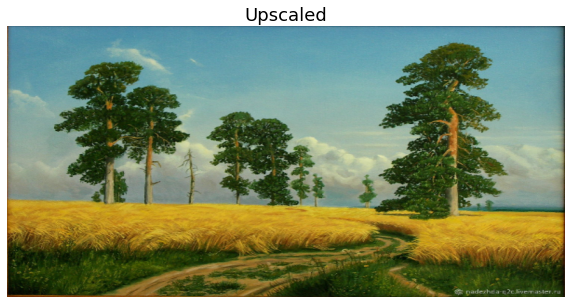

In [ ]:
panel = {
    'Original image' : img, 
    'Deleted seams' : img_carved, 
    'Compressed via SC' : sc,
    'Downscaled' : cv2.resize(img, dsize = (sc.shape[1], img.shape[0])),
    'Enlarged via SC ' : enlarged,
    'Upscaled' : cv2.resize(img, dsize = (enlarged.shape[1], img.shape[0]))
    }

for title, im in panel.items():
  plt.figure(figsize=(10, 10))
  plt.ylim(enlarged.shape[0], 0)
  plt.xlim(0, enlarged.shape[1])
  plt.axis('off')
  plt.title(title, fontsize=18)
  plt.imshow(im)
  plt.show()